In [421]:
!pip install tensorflow

In [422]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [472]:
acier_usure = r".\Expérimentations\Fraisage\Acier\Contrôle d'usure\Avec lubrifiant\40_2022_01_12_134028_75%_75%_L_US.xlsx"
acier_simp = r".\Expérimentations\Fraisage\Acier\Avec lubrifiant\19_2022_01_10_155909_75%_75%_L.xlsx"

In [473]:
df1 = pd.read_excel(acier_usure) #df d'expé sur de l'acier usé à 75%, 75% et avec lubrifiant

In [474]:
df2 = pd.read_excel(acier_simp) #df d'expé sur de l'acier à 75%, 75% et avec lubrifiant

In [475]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632483 entries, 0 to 632482
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        632483 non-null  object
 1   acc_broche  632483 non-null  object
 2   acc_table   632483 non-null  object
dtypes: object(3)
memory usage: 14.5+ MB


In [476]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680011 entries, 0 to 680010
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        680011 non-null  object
 1   acc_broche  680011 non-null  object
 2   acc_table   680011 non-null  object
dtypes: object(3)
memory usage: 15.6+ MB


# Analyse séquentielle

## Analyse des 4 dernières séquences avec les données brutes

In [477]:
df1 = df1.drop(df1.index[0])

In [478]:
df1["Time"] = df1["Time"].astype(float)

In [479]:
lower_bound1 = 687.0000
upper_bound1 = 822.5000
df1 = df1[df1["Time"].between(lower_bound1, upper_bound1)]

In [480]:
df1.tail()

,Time,acc_broche,acc_table
596423,822.4980,0.026664,0.00307
596424,822.4985,0.039658,-0.00179
596425,822.4990,-0.020219,-0.002042
596426,822.4995,-0.029232,-0.000115
596427,822.5000,-0.016973,-0.004323


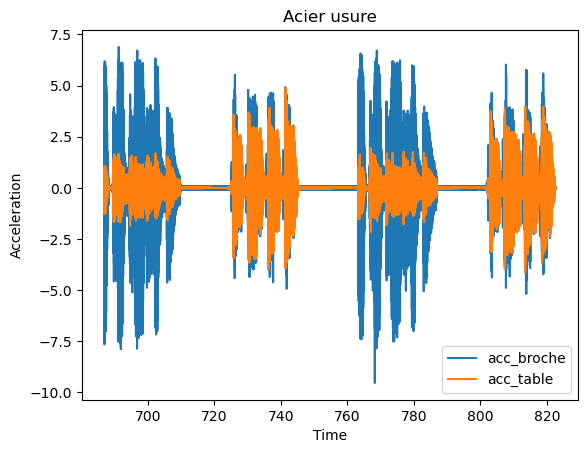

In [481]:
df1.plot(x='Time', y=['acc_broche', 'acc_table'])

plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acier usure')
plt.legend()

# Display the plot
plt.show()

In [482]:
X1_train = df1[df1["Time"].between(687.0000, 789.5000)]
X1_test = df1[df1["Time"].between(801.0000, 822.5000)]

y1_train = np.ones(X1_train.shape[0])
y1_test = np.ones(X1_test.shape[0])

In [483]:
X1_train.head()

,Time,acc_broche,acc_table
325427,687.0000,0.309724,0.00388
325428,687.0005,-0.572312,0.486797
325429,687.0010,1.139196,-0.208678
325430,687.0015,-1.48098,0.593135
325431,687.0020,2.184528,-1.032807


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


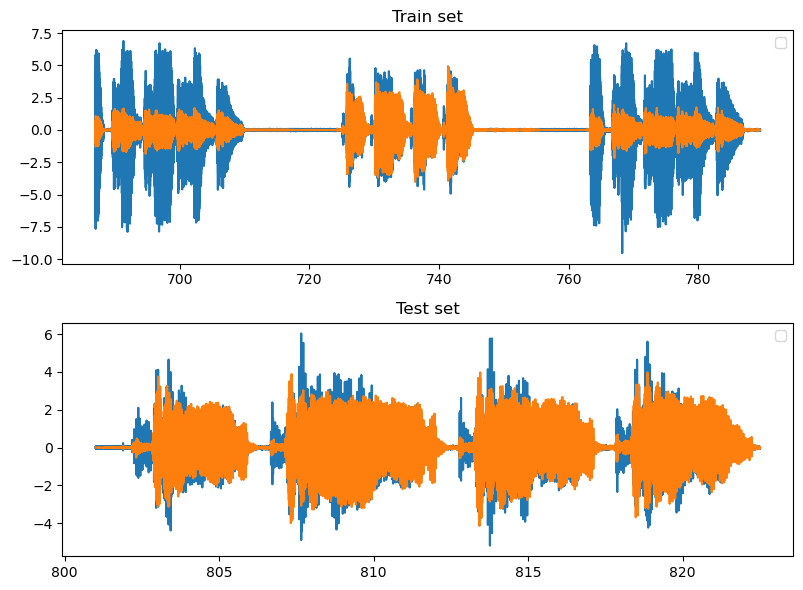

In [484]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(X1_train['Time'], X1_train[['acc_broche', 'acc_table']])
ax1.set_title('Train set')

ax2.plot(X1_test['Time'], X1_test[['acc_broche', 'acc_table']])
ax2.set_title('Test set')

ax1.legend()
ax2.legend()

plt.tight_layout()

plt.show()

In [485]:
df2 = df2.drop(df2.index[0])
df2["Time"] = df2["Time"].astype(float)

In [486]:
lower_bound2 = 691.0000
upper_bound2 = 827.5000
df2 = df2[df2["Time"].between(lower_bound2, upper_bound2)]

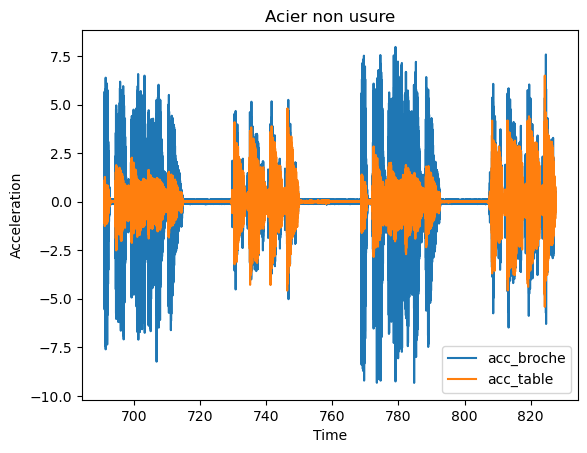

In [487]:
df2.plot(x='Time', y=['acc_broche', 'acc_table'])

plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acier non usure')
plt.legend()

# Display the plot
plt.show()

In [488]:
X2_train = df2[df2["Time"].between(691.0000, 792.5000)]
X2_test = df2[df2["Time"].between(807.5000, 827.5000)]

y2_train = np.zeros(X2_train.shape[0])
y2_test = np.zeros(X2_test.shape[0])

In [489]:
X2_test.head()

,Time,acc_broche,acc_table
566427,807.5000,-0.005292,-0.02531
566428,807.5005,0.04305,0.060497
566429,807.5010,0.033571,0.038578
566430,807.5015,-0.031887,0.015452
566431,807.5020,-0.057157,0.006586


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


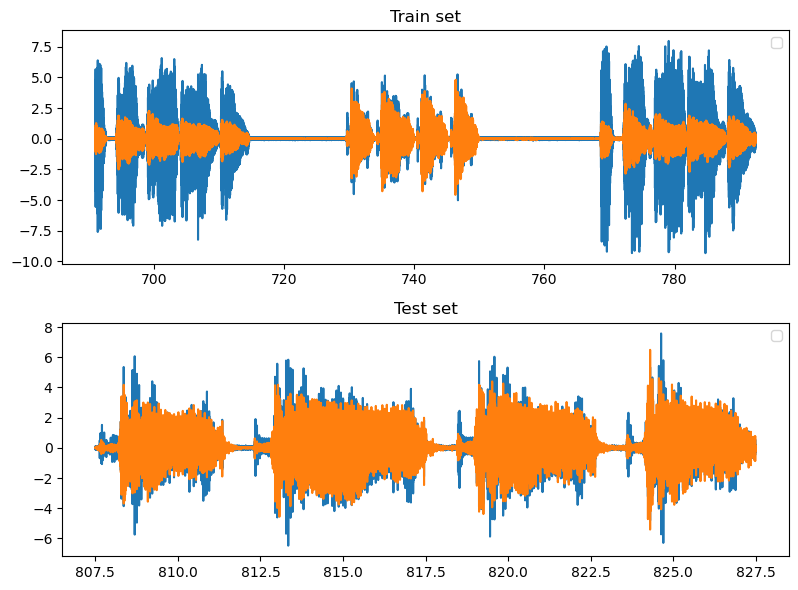

In [490]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(X2_train['Time'], X2_train[['acc_broche', 'acc_table']])
ax1.set_title('Train set')

ax2.plot(X2_test['Time'], X2_test[['acc_broche', 'acc_table']])
ax2.set_title('Test set')

ax1.legend()
ax2.legend()

plt.tight_layout()

plt.show()

In [491]:
train = pd.concat([X1_train, X2_train], ignore_index = True)
test = pd.concat([X1_test, X2_test], ignore_index = True)

In [492]:
#df['Time'] = pd.to_datetime(df['Time'], unit='s').dt.strftime('%M:%S.%f').str.rstrip('0')

In [493]:
# df['Time'] = pd.to_datetime(df['Time'])
# df.Time.dtype

In [494]:
# Séparer les caractéristiques (X) et la variable cible (y)
X_train = train[['Time', 'acc_broche', 'acc_table']]
y_train = np.concatenate((y1_train, y2_train))
X_test = test[['Time', 'acc_broche', 'acc_table']]
y_test = np.concatenate((y1_test, y2_test))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


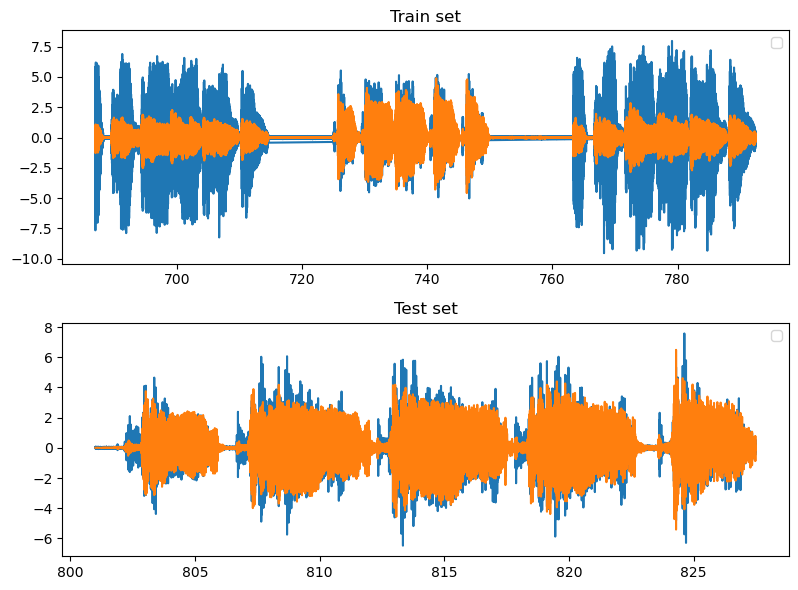

In [495]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(X_train['Time'], X_train[['acc_broche', 'acc_table']])
ax1.set_title('Train set')

ax2.plot(X_test['Time'], X_test[['acc_broche', 'acc_table']])
ax2.set_title('Test set')

ax1.legend()
ax2.legend()

plt.tight_layout()

plt.show()

In [496]:
# Créer un modèle de classification (Random Forest dans cet exemple)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [497]:
# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Précision du modèle :', accuracy)

Précision du modèle : 0.48192814630972747


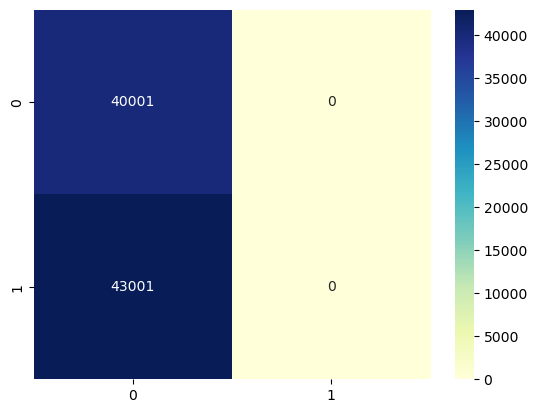

In [498]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)) , annot=True, cmap="YlGnBu", fmt="g")
plt.show()

In [499]:
# Classification avec MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

In [500]:
# Faire des prédictions sur les données de test
y_pred = mlp.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Précision du modèle :', accuracy)

Précision du modèle : 0.48192814630972747


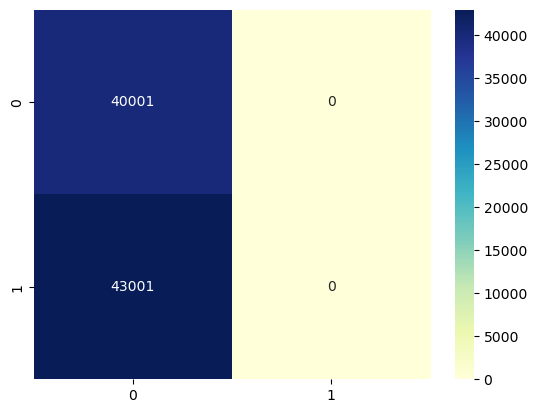

In [501]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)) , annot=True, cmap="YlGnBu", fmt="g")
plt.show()

### Caractéristiques statistiques

In [502]:
n_use = df1[["acc_broche", "acc_table"]]
w_size = 2000
df1.set_index("Time", inplace=True)
df2.set_index("Time", inplace=True)

In [503]:
def stats(df1):
    df1_stats = pd.DataFrame()
    for i in range(0, len(df1), w_size):
        groupe = df1.iloc[i:i+w_size]
        stats = groupe.agg(['std', 'median', 'max', 'min'])
        # Transposer le DataFrame et aplatir les colonnes
        df_flat = stats.stack()
        df_flat = df_flat.T.reset_index()
        df_flat["column"] = df_flat["level_0"]+"_"+df_flat["level_1"]
        df_flat.drop(["level_0", "level_1"], inplace=True, axis=1)
        df_flat["values"] = df_flat[0]
        df_flat.drop(df_flat.columns[0], axis=1, inplace=True)
        df_new = df_flat.set_index("column")
        df_new = df_new.transpose()
        df1_stats = pd.concat([df1_stats, df_new], axis=0)
    return df1_stats

In [504]:
df1_stats = stats(df1)

In [505]:
df1_stats.head()

column,std_acc_broche,std_acc_table,median_acc_broche,median_acc_table,max_acc_broche,max_acc_table,min_acc_broche,min_acc_table
values,1.613542,0.305933,-0.012245,0.026919,6.191269,1.081113,-7.652010,-1.284343
values,0.132060,0.023163,0.000401,0.000672,0.759906,0.147886,-0.868540,-0.248019
values,0.549872,0.183820,0.000082,0.000120,3.938624,1.643314,-4.576504,-1.664657
values,0.824176,0.243659,-0.015428,0.002053,3.535979,1.493383,-4.542416,-1.617501
values,2.098948,0.455764,0.038709,0.035563,6.892553,1.662570,-7.883570,-1.684812


In [506]:
df2_stats = stats(df2)

In [507]:
df2_stats.head()

column,std_acc_broche,std_acc_table,median_acc_broche,median_acc_table,max_acc_broche,max_acc_table,min_acc_broche,min_acc_table
values,1.796614,0.346735,0.004048,0.028856,6.383606,1.274296,-7.604778,-1.256104
values,0.527888,0.137116,0.000111,0.002615,3.807377,0.780836,-4.237509,-0.612244
values,0.043254,0.008254,-0.000359,0.000253,0.131907,0.016252,-0.138444,-0.015403
values,0.768562,0.239593,0.002330,-0.000176,4.958176,1.884602,-6.042545,-2.510503
values,1.503517,0.410524,-0.025801,0.014276,6.177950,1.750740,-6.644370,-1.969665


In [508]:
len(df1_stats)

136

In [509]:
X1_train = df1.head(100)
X1_test = df1.tail(36)

X2_train = df2.head(100)
X2_test = df2.tail(37)

In [510]:
X1_train.shape

(100, 2)

In [511]:
y1_train = np.ones(X1_train.shape[0])
y1_test = np.ones(X1_test.shape[0])

y2_train = np.zeros(X2_train.shape[0])
y2_test = np.zeros(X2_test.shape[0])

In [512]:
X_train = pd.concat([X1_train, X2_train])
X_test = pd.concat([X1_test, X2_test])

y_train = np.concatenate([y1_train, y2_train])
y_test = np.concatenate([y1_test, y2_test])

In [513]:
y_train.shape

(200,)

In [514]:
X_train

,acc_broche,acc_table
Time,,
687.0000,0.309724,0.00388
687.0005,-0.572312,0.486797
687.0010,1.139196,-0.208678
687.0015,-1.48098,0.593135
687.0020,2.184528,-1.032807
...,...,...
691.0475,0.536761,-0.170522
691.0480,0.061573,-0.173898
691.0485,-0.14963,0.015183


In [515]:
# Créer un modèle de classification (Random Forest dans cet exemple)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [516]:
# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Précision du modèle :', accuracy)

Précision du modèle : 0.4794520547945205


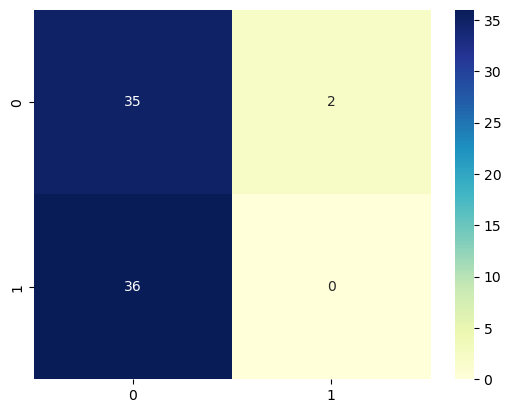

In [517]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)) , annot=True, cmap="YlGnBu", fmt="g")
plt.show()

## Avec une transformation des données

In [518]:
import librosa
import tensorflow as tf
from tensorflow.keras import layers

In [519]:
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)

In [520]:
df = pd.concat([df1, df2])

In [521]:
time = df['Time'].values
acc_table = df['acc_table'].values.astype(float)
acc_broche = df['acc_broche'].values.astype(float)
labels = y_train.astype(float)

In [522]:
stft_table = np.abs(librosa.stft(acc_table))
stft_broche = np.abs(librosa.stft(acc_broche))
#stft_labels = np.abs(librosa.stft(labels))

In [523]:
mfcc_table = librosa.feature.mfcc(S=librosa.power_to_db(stft_table))
mfcc_broche = librosa.feature.mfcc(S=librosa.power_to_db(stft_broche))

In [524]:
features = np.concatenate((mfcc_table, mfcc_broche), axis=0)
features = np.transpose(features)  # Reshape the features if needed

In [525]:
features.shape

(1063, 40)

In [526]:
labels.shape

(200,)

In [527]:
from sklearn.decomposition import PCA

In [528]:
pca = PCA()

d_pca = pca.fit_transform(features)

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(features.shape[1])], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,91843.042827,95.0,95.0
1,Dim2,2470.341885,3.0,98.0
2,Dim3,936.979139,1.0,99.0
3,Dim4,201.999360,0.0,99.0
4,Dim5,144.720819,0.0,99.0
5,Dim6,116.324480,0.0,99.0
6,Dim7,92.512731,0.0,99.0
7,Dim8,81.191169,0.0,99.0
8,Dim9,63.597761,0.0,99.0
9,Dim10,54.643540,0.0,99.0


In [529]:
pca_df = pd.DataFrame({
    "Dim1" : d_pca[:,0], 
    "Dim2" : d_pca[:,1],
    "Dim3" : d_pca[:,2]
})

<Axes: xlabel='Dim1', ylabel='Dim2'>

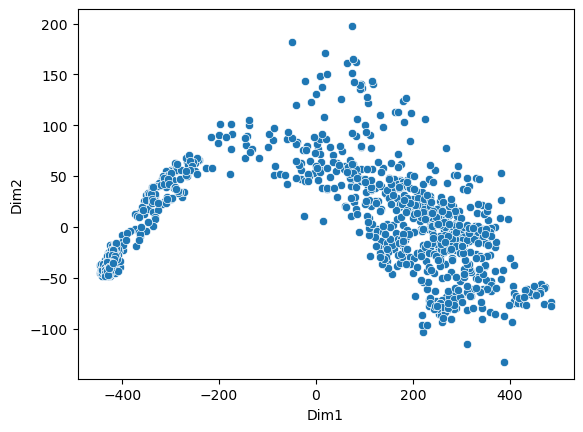

In [530]:
sns.scatterplot(data=pca_df, x="Dim1", y="Dim2")

### Extraction de caractéristiques 

In [531]:
from scipy.fft import fft
from scipy.stats import skew, kurtosis

In [532]:
df1.set_index("Time", inplace=True)
df2.set_index("Time", inplace=True)

In [643]:
def caracteristiques(df):
    
    """Fonction qui retourne un df de caractéristiques 
    telles que le ratio d'energie, 
    le crete à crete, l'écart type, le rms et le crest fatcor"""
    
    w_size = 2000 # 1s
    j=0
    df_new = pd.DataFrame()
    ## Calcul de l'énergie totale pour deduire le ratio d'energie
    fft_table = fft(df['acc_table'])
    fft_broche = fft(df['acc_broche'])
    tot_energy_table = np.sum(np.abs(fft_table)**2)
    tot_energy_broche = np.sum(np.abs(fft_broche)**2)
    for i in range(0, len(df), w_size):
        df_car = {}
        groupe = df.iloc[i:i+w_size]
        ## Energy ratio
        # Calcul de la transformée de fourier
        try:
            fft_table = fft(groupe['acc_table'])
            fft_broche = fft(groupe['acc_broche'])
        except:
            print(f'from {i} to {i+w_size}')
            print(groupe)
        # Calcul de l'energie totale par groupe
        energy_table = np.sum(np.abs(fft_table))
        energy_broche = np.sum(np.abs(fft_broche))
        # Calcul du ratio d'énergie
        energy_ratio_table = energy_table / tot_energy_table
        df_car['energy_table'] = round(energy_table, 4)
        df_car['energy_broche'] = round(energy_broche, 4)
        ## Peak to Peak
        peak_to_peak_table = round(max(groupe['acc_table']) - min(groupe['acc_table']), 4) 
        peak_to_peak_broche = round(max(groupe['acc_broche']) - min(groupe['acc_broche']), 4)
        df_car['peak_to_peak_table'] = peak_to_peak_table
        df_car['peak_to_peak_broche'] = peak_to_peak_broche
        ## standard deviation
        std_deviation_table = np.std(groupe['acc_table'].tolist())
        std_deviation_broche = np.std(groupe['acc_broche'].tolist())
        df_car['std_deviation_table'] = round(std_deviation_table, 4)
        df_car['std_deviation_broche'] = round(std_deviation_broche, 4)
        ## Root mean Square 
        rms_table = np.sqrt(np.mean(np.square(groupe['acc_table'].tolist())))
        rms_broche = np.sqrt(np.mean(np.square(groupe['acc_broche'].tolist())))
        df_car['rms_table'] = round(rms_table, 4)
        df_car['rms_broche'] = round(rms_broche, 4)
        ## Crest factor
        peak_value_table = np.max(groupe["acc_table"].tolist())
        peak_value_broche = np.max(groupe["acc_broche"].tolist())
        crest_factor_table = peak_value_table / rms_table
        crest_factor_broche = peak_value_broche / rms_broche
        df_car['crest_factor_table'] = round(crest_factor_table, 4)
        df_car['crest_factor_broche'] = round(crest_factor_broche, 4)
        ## skewness (asymétrie)
        skew_table = skew(groupe['acc_table'].tolist())
        skew_broche = skew(groupe['acc_broche'].tolist())
        df_car['skew_table'] = round(skew_table, 4)
        df_car['skew_broche'] = round(skew_broche, 4)
        ## Kurtosis (Aplatissement)
        kurtosis_table = kurtosis(groupe['acc_table'].tolist())
        kurtosis_broche = kurtosis(groupe['acc_broche'].tolist())
        df_car['kurtosis_table'] = round(kurtosis_table, 4)
        df_car['kurtosis_broche'] = round(kurtosis_broche, 4)
        df_car = pd.DataFrame(df_car, index=[j])
        j+=1
        #display(df_car)
        df_new = pd.concat([df_new, df_car], axis=0)
    return df_new

In [645]:
df1_car = caracteristiques(df1)
df2_car = caracteristiques(df2)

In [646]:
df1_car.head()

,energy_table,energy_broche,peak_to_peak_table,peak_to_peak_broche,std_deviation_table,std_deviation_broche,rms_table,rms_broche,crest_factor_table,crest_factor_broche,skew_table,skew_broche,kurtosis_table,kurtosis_broche
0,9035.4474,49444.5163,2.3655,13.8433,0.3059,1.6131,0.3059,1.6131,3.5347,3.8380,-0.2559,-0.2791,1.1708,3.5658
1,1221.0301,6622.9989,0.3959,1.6284,0.0232,0.1320,0.0232,0.1320,6.3863,5.7557,-1.8168,-0.5860,16.6768,11.5507
2,7352.3851,22155.8175,3.3080,8.5151,0.1838,0.5497,0.1838,0.5497,8.9420,7.1646,0.0093,-0.4169,31.8238,23.1596
3,9914.1998,31411.6981,3.1109,8.0784,0.2436,0.8240,0.2436,0.8240,6.1305,4.2914,0.3288,-0.2688,8.7213,4.8461
4,19663.3941,80722.2749,3.3474,14.7761,0.4556,2.0984,0.4557,2.0984,3.6488,3.2846,-0.4311,-0.1697,1.2291,0.9500


In [600]:
df2_car.head()

,energy_table,energy_broche,peak_to_peak_table,peak_to_peak_broche,std_deviation_table,std_deviation_broche,rms_table,rms_broche,crest_factor_table,crest_factor_broche,skew_table,skew_broche,kurtosis_table,kurtosis_broche
0,9035.4474,49444.5163,2.3655,13.8433,0.3059,1.6131,0.3059,1.6131,3.5347,3.8380,-0.2559,-0.2791,1.1708,3.5658
1,1221.0301,6622.9989,0.3959,1.6284,0.0232,0.1320,0.0232,0.1320,6.3863,5.7557,-1.8168,-0.5860,16.6768,11.5507
2,7352.3851,22155.8175,3.3080,8.5151,0.1838,0.5497,0.1838,0.5497,8.9420,7.1646,0.0093,-0.4169,31.8238,23.1596
3,9914.1998,31411.6981,3.1109,8.0784,0.2436,0.8240,0.2436,0.8240,6.1305,4.2914,0.3288,-0.2688,8.7213,4.8461
4,19663.3941,80722.2749,3.3474,14.7761,0.4556,2.0984,0.4557,2.0984,3.6488,3.2846,-0.4311,-0.1697,1.2291,0.9500


In [647]:
display(len(df1_car))
display(len(df2_car))

136

137

In [658]:
X1_train = df1_car.iloc[:100]
X1_test = df1_car.iloc[100:]

y1_train = np.ones(X1_train.shape[0])
y1_test = np.ones(X1_test.shape[0])

In [660]:
X2_train = df2_car.iloc[:100]
X2_test = df2_car.iloc[100:]

y2_train = np.zeros(X2_train.shape[0])
y2_test = np.zeros(X2_test.shape[0])

In [661]:
X_train = pd.concat([X1_train, X2_train])
X_test = pd.concat([X1_test, X2_test])

y_train = np.concatenate([y1_train, y2_train])
y_test = np.concatenate([y1_test, y2_test])

In [662]:
# Créer un modèle de classification (Random Forest dans cet exemple)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [663]:
# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, y_pred)
print('Précision du modèle :', accuracy)

Précision du modèle : 0.7397260273972602
